In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as lines
import matplotlib.colors as clr
import seaborn as sns
from statannot import add_stat_annotation
from rich.progress import track

sns.set(color_codes=True, style="white")
pd.options.mode.chained_assignment = None  # default='warn'

In [7]:
os.chdir(
    "/Volumes/lsa-nwalter/Guoming_Gao_turbo/Walterlab_server/PROCESSED_DATA/RNA-diffusion-in-FUS/RNAinFUS_PaperFigures/Fig4_regulation/crowding_aging_Hela"
)
lst_labels = [
    "0Dex, -, 0h",
    "0Dex, -, 3h",
    "0Dex, -, 6h",
    "0Dex, -, 8h",
    "0Dex, Hela, 0h",
    "10Dex, -, 0h",
    "10Dex, -, 3h",
    "10Dex, -, 6h",
    "10Dex, -, 8h",
    "10Dex, Hela, 0h",
]

colors = [
    "#333232",
    "#f7b801",
    "#87a878",
]

## Calculate Fractions and Save

#### Parameters

In [3]:
# Displacement threshold for immobile molecules
immobile_stepsize_threshold_nm = 30
# alpha component threshold for constrained diffusion
threshold_alpha = 0.7

dict_input_path = {
    "0Dex, -, 0h": "SPT_results_AIO_concat-0Dex_noTR_0hr.csv",
    "0Dex, -, 3h": "SPT_results_AIO_concat-0Dex_noTR_3hr.csv",
    "0Dex, -, 6h": "SPT_results_AIO_concat-0Dex_noTR_6hr.csv",
    "0Dex, -, 8h": "SPT_results_AIO_concat-0Dex_noTR_8hr.csv",
    "0Dex, Hela, 0h": "SPT_results_AIO_concat-0Dex_helaTR_1hr.csv",
    "10Dex, -, 0h": "SPT_results_AIO_concat-10Dex_noTR_0hr.csv",
    "10Dex, -, 3h": "SPT_results_AIO_concat-10Dex_noTR_3hr.csv",
    "10Dex, -, 6h": "SPT_results_AIO_concat-10Dex_noTR_6hr.csv",
    "10Dex, -, 8h": "SPT_results_AIO_concat-10Dex_noTR_8hr.csv",
    "10Dex, Hela, 0h": "SPT_results_AIO_concat-10Dex_helaTR_0hr.csv",
}
# calculate error bounds
s_per_frame = 0.02
# Output file structure
columns = [
    "label",
    "replicate_prefix",
    "N, Total",
    "N, Mobile",
    "N, Constrained",
    "Static Fraction",
    "Constrained Fraction",
]

#### Calculations (immobile by mean step size)

In [5]:
lst_rows_of_df = []
for key in track(dict_input_path.keys()):
    df_current = pd.read_csv(dict_input_path[key])
    df_current = df_current.astype(
        {"linear_fit_log10D": float, "mean_stepsize_nm": float, "alpha": float}
    )
    # all filenames within the current condition/file
    all_filenames = df_current["filename"].unique().tolist()
    # filename prefix for each replicate
    replicate_prefixs = np.unique([f.split("FOV")[0] for f in all_filenames])

    for prefix in replicate_prefixs:
        current_replicate_filenames = [f for f in all_filenames if prefix in f]
        df_current_replicate = df_current[
            df_current["filename"].isin(current_replicate_filenames)
        ]

        # Judege if immobile by mean step size
        df_mobile = df_current_replicate[
            df_current_replicate["mean_stepsize_nm"] >= immobile_stepsize_threshold_nm
        ]

        # Judge if constrained by alpha component
        df_constrained = df_mobile[df_mobile["alpha"] <= threshold_alpha]

        N_total = df_current_replicate.shape[0]
        N_mobile = df_mobile.shape[0]
        N_constrained = df_constrained.shape[0]

        if N_constrained < 1:
            continue

        F_immobile = (N_total - N_mobile) / N_total
        F_constrained = N_constrained / N_mobile

        # save
        lst_rows_of_df.append(
            [
                key,
                prefix,
                N_total,
                N_mobile,
                N_constrained,
                F_immobile,
                F_constrained,
            ]
        )

df_save = pd.DataFrame.from_records(
    lst_rows_of_df,
    columns=columns,
)
df_save.to_csv("N_and_Fraction_per_replicate_by_stepsize.csv", index=False)

Output()

## Load data

In [8]:
data = pd.read_csv("N_and_Fraction_per_replicate_by_stepsize.csv")

## Prepare plot df, calculate p vals

In [13]:
N_total = data["N, Total"].to_numpy(int)
N_mobile = data["N, Mobile"].to_numpy(int)
N_immobile = N_total - N_mobile
N_constrained = data["N, Constrained"].to_numpy(int)
N_normal = N_mobile - N_constrained

frac_immobile = N_immobile / N_total
frac_constrained = N_constrained / N_total
frac_normal = N_normal / N_total

data["Immobile"] = frac_immobile
data["Constrained"] = frac_constrained
data["Normal"] = frac_normal

In [22]:
df_mean_error = pd.DataFrame(
    {
        "label": data["label"].unique(),
        "F_immobile_mean": [
            data[data["label"] == label]["Immobile"].mean()
            for label in data["label"].unique()
        ],
        "F_immobile_sem": [
            data[data["label"] == label]["Immobile"].sem()
            for label in data["label"].unique()
        ],
        "F_immobile_std": [
            data[data["label"] == label]["Immobile"].std()
            for label in data["label"].unique()
        ],
        "F_constrained_mean": [
            data[data["label"] == label]["Constrained"].mean()
            for label in data["label"].unique()
        ],
        "F_constrained_sem": [
            data[data["label"] == label]["Constrained"].sem()
            for label in data["label"].unique()
        ],
        "F_constrained_std": [
            data[data["label"] == label]["Constrained"].std()
            for label in data["label"].unique()
        ],
        "F_normal_mean": [
            data[data["label"] == label]["Normal"].mean()
            for label in data["label"].unique()
        ],
        "F_normal_sem": [
            data[data["label"] == label]["Normal"].sem()
            for label in data["label"].unique()
        ],
        "F_normal_std": [
            data[data["label"] == label]["Normal"].std()
            for label in data["label"].unique()
        ],
        "nobs": [
            data[data["label"] == label].shape[0]
            for label in data["label"].unique()
        ],  # number of observations
    },
    dtype=object,
)

In [53]:
from scipy.stats import ttest_ind_from_stats

def p_annot(p):
    """
    p-value annotation legend:
    ns: 0.05 < p <= 1
    *: 0.01 < p <= 0.05
    **: 0.001 < p <= 0.01
    ***: 0.0001 < p <= 0.001
    ****: p <= 0.0001
    """
    if p > 0.05:
        return "ns"
    elif p > 0.01:
        return "*"
    elif p > 0.001:
        return "**"
    elif p > 0.0001:
        return "***"
    else:
        return "****"


def compare2labels(label1, label2):
    print("(", label1, ") vs (", label2, "):")
    _, pval = ttest_ind_from_stats(
        mean1=df_mean_error[df_mean_error["label"] == label1][
            "F_normal_mean"
        ].squeeze(),
        std1=df_mean_error[df_mean_error["label"] == label1]["F_normal_std"].squeeze(),
        nobs1=df_mean_error[df_mean_error["label"] == label1]["nobs"].squeeze(),
        mean2=df_mean_error[df_mean_error["label"] == label2][
            "F_normal_mean"
        ].squeeze(),
        std2=df_mean_error[df_mean_error["label"] == label2]["F_normal_std"].squeeze(),
        nobs2=df_mean_error[df_mean_error["label"] == label2]["nobs"].squeeze(),
        equal_var=False,
        alternative="two-sided",
    )
    print("p value of normal fraction:", pval, p_annot(pval))
    _, pval = ttest_ind_from_stats(
        mean1=df_mean_error[df_mean_error["label"] == label1][
            "F_constrained_mean"
        ].squeeze(),
        std1=df_mean_error[df_mean_error["label"] == label1][
            "F_constrained_std"
        ].squeeze(),
        nobs1=df_mean_error[df_mean_error["label"] == label1]["nobs"].squeeze(),
        mean2=df_mean_error[df_mean_error["label"] == label2][
            "F_constrained_mean"
        ].squeeze(),
        std2=df_mean_error[df_mean_error["label"] == label2][
            "F_constrained_std"
        ].squeeze(),
        nobs2=df_mean_error[df_mean_error["label"] == label2]["nobs"].squeeze(),
        equal_var=False,
        alternative="two-sided",
    )
    print("p value of constrained fraction:", pval, p_annot(pval))
    _, pval = ttest_ind_from_stats(
        mean1=df_mean_error[df_mean_error["label"] == label1][
            "F_immobile_mean"
        ].squeeze(),
        std1=df_mean_error[df_mean_error["label"] == label1][
            "F_immobile_std"
        ].squeeze(),
        nobs1=df_mean_error[df_mean_error["label"] == label1]["nobs"].squeeze(),
        mean2=df_mean_error[df_mean_error["label"] == label2][
            "F_immobile_mean"
        ].squeeze(),
        std2=df_mean_error[df_mean_error["label"] == label2][
            "F_immobile_std"
        ].squeeze(),
        nobs2=df_mean_error[df_mean_error["label"] == label2]["nobs"].squeeze(),
        equal_var=False,
        alternative="two-sided",
    )
    print("p value of immobile fraction:", pval, p_annot(pval))

In [41]:
data['label'].unique()

array(['0Dex, -, 0h', '0Dex, -, 3h', '0Dex, -, 6h', '0Dex, -, 8h',
       '0Dex, Hela, 0h', '10Dex, -, 0h', '10Dex, -, 3h', '10Dex, -, 6h',
       '10Dex, -, 8h', '10Dex, Hela, 0h'], dtype=object)

In [54]:
compare2labels("0Dex, -, 0h", "0Dex, -, 8h")
compare2labels("10Dex, -, 0h", "10Dex, -, 8h")
compare2labels("0Dex, -, 0h", "10Dex, -, 0h")
compare2labels("0Dex, -, 8h", "10Dex, -, 8h")

( 0Dex, -, 0h ) vs ( 0Dex, -, 8h ):
p value of normal fraction: 0.3106062140244792 ns
p value of constrained fraction: 0.09731727422702056 ns
p value of immobile fraction: 0.101331081084373 ns
( 10Dex, -, 0h ) vs ( 10Dex, -, 8h ):
p value of normal fraction: 0.0009328574872258043 ***
p value of constrained fraction: 0.0008080706421852832 ***
p value of immobile fraction: 0.8026540666393416 ns
( 0Dex, -, 0h ) vs ( 10Dex, -, 0h ):
p value of normal fraction: 0.16104005143504235 ns
p value of constrained fraction: 0.671743109379146 ns
p value of immobile fraction: 0.16413115032382455 ns
( 0Dex, -, 8h ) vs ( 10Dex, -, 8h ):
p value of normal fraction: 0.48630561044002585 ns
p value of constrained fraction: 0.6022935030845671 ns
p value of immobile fraction: 0.8478898272710905 ns


In [55]:
compare2labels("0Dex, -, 0h", "0Dex, Hela, 0h")
compare2labels("10Dex, -, 0h", "10Dex, Hela, 0h")
compare2labels("0Dex, -, 0h", "10Dex, -, 0h")
compare2labels("0Dex, Hela, 0h", "10Dex, Hela, 0h")

( 0Dex, -, 0h ) vs ( 0Dex, Hela, 0h ):
p value of normal fraction: 0.1163765122696564 ns
p value of constrained fraction: 0.9744286878145616 ns
p value of immobile fraction: 0.2085024344629256 ns
( 10Dex, -, 0h ) vs ( 10Dex, Hela, 0h ):
p value of normal fraction: 0.09643086503745801 ns
p value of constrained fraction: 0.2357966164687454 ns
p value of immobile fraction: 0.020350185006375112 *
( 0Dex, -, 0h ) vs ( 10Dex, -, 0h ):
p value of normal fraction: 0.16104005143504235 ns
p value of constrained fraction: 0.671743109379146 ns
p value of immobile fraction: 0.16413115032382455 ns
( 0Dex, Hela, 0h ) vs ( 10Dex, Hela, 0h ):
p value of normal fraction: 0.35399612530184527 ns
p value of constrained fraction: 0.4693162834226555 ns
p value of immobile fraction: 0.146692448832565 ns


## Plots

#### Aging & Dextran

F_immobile_mean :
label: ['0Dex, -, 0h', '0Dex, -, 3h', '0Dex, -, 6h', '0Dex, -, 8h']
fraction: [5.915485843866704 4.328607247527059 3.458537746772482 3.0105827664744833]
SEM: [1.4278867165434412 0.8398534285708371 0.6399119346543388
 0.6562066422565433]

F_constrained_mean :
label: ['0Dex, -, 0h', '0Dex, -, 3h', '0Dex, -, 6h', '0Dex, -, 8h']
fraction: [83.47765527821699 86.85365471976867 90.05307148045864 89.26059808857374]
SEM: [1.937139376300244 1.1870554547954357 1.4738767063722906
 2.3170897488800404]

F_normal_mean :
label: ['0Dex, -, 0h', '0Dex, -, 3h', '0Dex, -, 6h', '0Dex, -, 8h']
fraction: [10.606858877916315 8.817738032704279 6.488390772768886 7.728819144951768]
SEM: [1.7231340805230164 0.8621779229272516 1.0300151785451197
 1.9969233907170092]

F_immobile_mean :
label: ['10Dex, -, 0h', '10Dex, -, 3h', '10Dex, -, 6h', '10Dex, -, 8h']
fraction: [3.5924086010288994 4.673766209878245 2.696987392705534 3.2714697568554953]
SEM: [0.4651265823287008 0.8957658655657801 0.62245470078

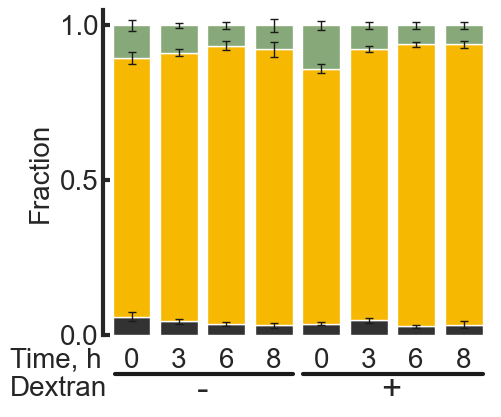

In [49]:
fig = plt.figure(figsize=(5, 4))
x = [1, 2, 3, 4]
labels = [
    "0Dex, -, 0h",
    "0Dex, -, 3h",
    "0Dex, -, 6h",
    "0Dex, -, 8h",
]
df_fractions = df_mean_error[df_mean_error["label"].isin(labels)]
bottom = np.zeros(len(x))
categories = ["F_immobile_mean", "F_constrained_mean", "F_normal_mean"]
for i in range(len(categories)):
    plt.bar(
        x=x,
        height=df_fractions[categories[i]],
        yerr=df_fractions[categories[i][:-4] + "sem"],
        error_kw={"elinewidth": 1},
        capsize=3,
        label=labels,
        bottom=bottom,
        color=colors[i],
    )
    print(categories[i], ":")
    print("label:", labels)
    print("fraction:", df_fractions[categories[i]].to_numpy() * 100)
    print("SEM:", df_fractions[categories[i][:-4] + "sem"].to_numpy() * 100)
    print()
    bottom += df_fractions[categories[i]]

x = [5, 6, 7, 8]
labels = [
    "10Dex, -, 0h",
    "10Dex, -, 3h",
    "10Dex, -, 6h",
    "10Dex, -, 8h",
]
df_fractions = df_mean_error[df_mean_error["label"].isin(labels)]
bottom = np.zeros(len(x))
categories = ["F_immobile_mean", "F_constrained_mean", "F_normal_mean"]
for i in range(len(categories)):
    plt.bar(
        x=x,
        height=df_fractions[categories[i]],
        yerr=df_fractions[categories[i][:-4] + "sem"],
        error_kw={"elinewidth": 1},
        capsize=3,
        label=labels,
        bottom=bottom,
        color=colors[i],
    )
    print(categories[i], ":")
    print("label:", labels)
    print("fraction:", df_fractions[categories[i]].to_numpy() * 100)
    print("SEM:", df_fractions[categories[i][:-4] + "sem"].to_numpy() * 100)
    print()
    bottom += df_fractions[categories[i]]

plt.ylim(0, 1.05)
canvas_width = 0.6
plt.xlim(1 - canvas_width, 8 + canvas_width)
plt.ylabel("Fraction", size=20)
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8], ["0", "3", "6", "8", "0", "3", "6", "8"], size=20)
plt.yticks([0, 0.5, 1], size=20)
plt.gca().spines[:].set_linewidth(3)
plt.gca().spines[['right', 'top', 'bottom']].set_visible(False)
plt.gca().tick_params(
    axis="y",
    which="major",
    labelsize=20,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=3,
)
plt.xlabel("")
fig.text(0, 0.06, "Time, h", fontsize=20)
line_y = 0.045
fig.add_artist(lines.Line2D([0.21, 0.565], [line_y, line_y], c="k", lw=3))
fig.add_artist(lines.Line2D([0.585, 0.945], [line_y, line_y], c="k", lw=3))
second_row_y = -0.02
fig.text(0, second_row_y + 0.01, "Dextran", fontsize=20)
fig.text(0.373, second_row_y, "-", fontsize=25)
fig.text(0.742, second_row_y, "+", fontsize=25)
plt.tight_layout()


plt.savefig(
    "Fig3_Fracs_aging_Dex_combined.png", format="png", bbox_inches="tight", dpi=300
)

#### Aging, 10% Dextran

fig = plt.figure(figsize=(3, 3))
x = [1, 2, 3, 4]
labels = [
    "10Dex, -, 0h",
    "10Dex, -, 3h",
    "10Dex, -, 6h",
    "10Dex, -, 8h",
]
df_fractions = df_mean_error[df_mean_error["label"].isin(labels)]
bottom = np.zeros(len(x))
categories = ["F_immobile_mean", "F_constrained_mean", "F_normal_mean"]
for i in range(len(categories)):
    plt.bar(
        x=x,
        height=df_fractions[categories[i]],
        yerr=df_fractions[categories[i][:-4] + "sem"],
        error_kw={"elinewidth": 1},
        capsize=3,
        label=labels,
        bottom=bottom,
        color=colors[i],
    )
    bottom += df_fractions[categories[i]]
plt.title("+ 10% Dex", size=15)
plt.ylim(0, 1.05)
plt.ylabel("Fraction", size=15)
plt.xticks(x, ["0", "3", "6", "8"], size=15)
plt.yticks([0, 0.5, 1], size=15)
fig.text(0.05, 0.075, "Time, h", fontsize=15)
plt.gca().spines[:].set_linewidth(1)
plt.gca().tick_params(
    axis="y",
    which="major",
    labelsize=15,
    direction="out",
    bottom=True,
    left=True,
    length=5,
    width=1,
)
plt.xlabel("")
plt.tight_layout()
plt.savefig("Fig3_Fracs_aging_10Dex_by_stepsize.png", format="png", bbox_inches="tight", dpi=300)

#### Compare RNA

F_immobile_mean :
label: ['0Dex, -, 0h', '0Dex, Hela, 0h', '10Dex, -, 0h', '10Dex, Hela, 0h']
fraction: [5.915485843866704 9.072402741956067 3.5924086010288994 5.358789761383928]
SEM: [1.4278867165434412 1.6652119676331554 0.4651265823287008
 0.4771672965527818]

F_constrained_mean :
label: ['0Dex, -, 0h', '0Dex, Hela, 0h', '10Dex, -, 0h', '10Dex, Hela, 0h']
fraction: [83.47765527821699 83.55502810079196 82.4348324141561 85.19163605786768]
SEM: [1.937139376300244 1.3092362019967059 1.4173070106869923
 1.6861106284718361]

F_normal_mean :
label: ['0Dex, -, 0h', '0Dex, Hela, 0h', '10Dex, -, 0h', '10Dex, Hela, 0h']
fraction: [10.606858877916315 7.372569157251972 13.972758984814998 9.449574180748405]
SEM: [1.7231340805230164 0.545824895774937 1.4734957017689445 1.985492443253636]



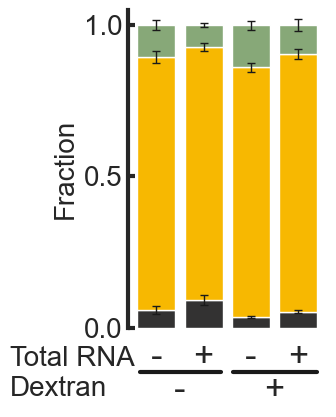

In [32]:
fig = plt.figure(figsize=(3.1, 4))
x = [1, 2, 3, 4]
labels = [
    "0Dex, -, 0h",
    "0Dex, Hela, 0h",
    "10Dex, -, 0h",
    "10Dex, Hela, 0h",
]
df_fractions = df_mean_error[df_mean_error["label"].isin(labels)]
bottom = np.zeros(len(x))
categories = ["F_immobile_mean", "F_constrained_mean", "F_normal_mean"]
for i in range(len(categories)):
    plt.bar(
        x=x,
        height=df_fractions[categories[i]],
        yerr=df_fractions[categories[i][:-4] + "sem"],
        error_kw={"elinewidth": 1},
        capsize=3,
        label=labels,
        bottom=bottom,
        color=colors[i],
    )
    print(categories[i], ":")
    print("label:", labels)
    print("fraction:", df_fractions[categories[i]].to_numpy() * 100)
    print("SEM:", df_fractions[categories[i][:-4] + "sem"].to_numpy() * 100)
    print()
    bottom += df_fractions[categories[i]]

plt.ylim(0, 1.05)
canvas_width = 0.6
plt.xlim(1 - canvas_width, 4 + canvas_width)
plt.ylabel("Fraction", size=20)
plt.xticks(x, ["-", "+", "-", "+"], size=25)
plt.yticks([0, 0.5, 1], size=20)
plt.gca().spines[:].set_linewidth(3)
plt.gca().spines[['right', 'top', 'bottom']].set_visible(False)
plt.gca().tick_params(
    axis="y",
    which="major",
    labelsize=20,
    direction="in",
    bottom=True,
    left=True,
    length=5,
    width=3,
)
plt.xlabel("")
fig.text(-0.08, 0.065, "Total RNA", fontsize=20)
line_y = 0.05
fig.add_artist(lines.Line2D([0.34, 0.6], [line_y, line_y], c="k", lw=3))
fig.add_artist(lines.Line2D([0.64, 0.91], [line_y, line_y], c="k", lw=3))
second_row_y = -0.02
fig.text(-0.08, second_row_y + 0.01, "Dextran", fontsize=20)
fig.text(0.45, second_row_y, "-", fontsize=25)
fig.text(0.74, second_row_y, "+", fontsize=25)
plt.tight_layout()
plt.savefig(
    "Fig3_Fracs_totalRNA_by_stepsize.png", format="png", bbox_inches="tight", dpi=300
)